In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# ========== python ==========
import os
from logging import Logger
from pathlib import Path
import gc
# noinspection PyUnresolvedReferences
from typing import List, Dict, Tuple, Optional, Union, Callable, Final, Literal, get_args
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
PROJECT_DIR = Path().resolve().parents[1]
os.chdir(PROJECT_DIR)
SEED: Final = 42

In [2]:
from utils.setup import load_param, easy_logger, get_device
from utils.torch import load_model, torch_fix_seed
from torch.utils.tensorboard.writer import SummaryWriter
from ignite.handlers import Checkpoint
from run_for_KGC import main_function
logger = easy_logger('log/test.log')

In [3]:
args = load_param('saved_models/kgc/DevilsFoot090/03/param.pkl')
device = get_device(device_name='cpu', logger=logger)
# args.pre_train = True
args.logger = logger
args.device = device
args.batch_size = 1
args.max_len=512
args.tensorboard_dir=None
args.only_load_trainer_evaluator=True
args.pre_train=False
del args.optuna_file, args.device_name, args.pid
del args.study_name, args.n_trials
logger.info(args)

2023-01-01 10:07:09 - INFO - 1419756205.py - 13 - Namespace(notebook=False, train_anyway=False, logfile='saved_models/kgc/DevilsFoot090/03/log.log', param_file='saved_models/kgc/DevilsFoot090/03/param.pkl', tensorboard_dir=None, checkpoint_dir='saved_models/kgc/DevilsFoot090/03/checkpoint/', model_path='saved_models/kgc/DevilsFoot090/03/model.pth', model_version='03', resume_from_checkpoint=False, resume_from_last_point=False, only_load_trainer_evaluator=True, resume_checkpoint_path=None, console_level='info', pre_train=False, train_valid_test=False, only_train=True, use_for_challenge100=False, use_for_challenge090=True, use_for_challenge075=False, use_title='DevilsFoot', do_optuna=False, story_special_num=5, relation_special_num=5, entity_special_num=5, padding_token_e=0, cls_token_e=1, mask_token_e=2, sep_token_e=3, bos_token_e=4, padding_token_r=0, cls_token_r=1, mask_token_r=2, sep_token_r=3, bos_token_r=4, padding_token_s=0, cls_token_s=1, mask_token_s=2, sep_token_s=3, bos_token_

In [4]:
torch_fix_seed(seed=SEED)
model, data_dict = main_function(args, logger=logger)
encoder_last_layer = model.transformer.layers[-1]
model.eval()
dataset_train, dataset_valid, dataset_test = data_dict['datasets']
triple = dataset_train.triple
data_helper = data_dict['data_helper']
evaluator = data_dict['train_items']['evaluator']
load_model(model, args.model_path, device)
print(len(data_helper.processed_train_triple), len(triple))

2023-01-01 10:07:09 - INFO - run_for_KGC.py - 775 - ----- make datahelper start. -----
2023-01-01 10:07:09 - INFO - data_helper.py - 207 - ==========Show MyRawData==========
2023-01-01 10:07:09 - INFO - data_helper.py - 208 - entity_length: 7844
2023-01-01 10:07:09 - INFO - data_helper.py - 209 - relation_length: 63
2023-01-01 10:07:09 - INFO - data_helper.py - 212 - ==========Show MyRawData==========
2023-01-01 10:07:09 - INFO - data_helper.py - 440 - ==========Show DataHelper==========
2023-01-01 10:07:09 - INFO - data_helper.py - 441 - ==========
2023-01-01 10:07:09 - INFO - data_helper.py - 207 - ==========Show MyRawData==========
2023-01-01 10:07:09 - INFO - data_helper.py - 208 - entity_length: 7844
2023-01-01 10:07:09 - INFO - data_helper.py - 209 - relation_length: 63
2023-01-01 10:07:09 - INFO - data_helper.py - 212 - ==========Show MyRawData==========
2023-01-01 10:07:09 - INFO - data_helper.py - 443 - ==========
2023-01-01 10:07:09 - INFO - data_helper.py - 445 - entity_spec

13940 17117


In [5]:
from run_for_KGC import get_all_tokens
to_token = "{}".format
PAD_E = to_token("pad_e")
CLS_E = to_token('cls_e')
MASK_E: Final[str] = to_token('mask_e')
SEP_E: Final[str] = to_token('sep_e')
BOS_E: Final[str] = to_token('bos_e')
PAD_R: Final[str] = to_token('pad_r')
CLS_R: Final[str] = to_token('cls_r')
MASK_R: Final[str] = to_token('mask_r')
SEP_R: Final[str] = to_token('sep_r')
BOS_R: Final[str] = to_token('bos_r')

((pad_token_e, pad_token_r), (cls_token_e, cls_token_r), (mask_token_e, mask_token_r),
     (sep_token_e, sep_token_r), (bos_token_e, bos_token_r)) = get_all_tokens(args)

data_helper.set_special_names(
    index2name_entity={pad_token_e: PAD_E, cls_token_e: CLS_E, mask_token_e: MASK_E, sep_token_e: SEP_E, bos_token_e: BOS_E},
    index2name_relation={pad_token_r: PAD_R, cls_token_r: CLS_R, mask_token_r: MASK_R, sep_token_r: SEP_R, bos_token_r: BOS_R},
)

In [6]:
entities = data_helper.processed_entities
d_e = {e: i for i, e in enumerate(entities)}
relations = data_helper.processed_relations
d_r = {r: i for i, r in enumerate(relations)}
triple_df = pd.DataFrame([(entities[_t[0]], relations[_t[1]], entities[_t[2]]) for _t in triple], columns=['head', 'relation', 'tail']) 
# story_entities = triple_df
# triple_df

In [7]:
def extract(model, target, inputs):
    feature = None

    def forward_hook(module, inputs, _):
        # 順伝搬の出力を features というグローバル変数に記録する
        global features
        # 1. detach でグラフから切り離す。
        # 2. clone() でテンソルを複製する。モデルのレイヤーで ReLU(inplace=True) のように
        #    inplace で行う層があると、値がその後のレイヤーで書き換えられてまい、
        #    指定した層の出力が取得できない可能性があるため、clone() が必要。
        x, _, _ = inputs
        outputs = module.forward(x, x, x, need_weights=True)[1]
        features = outputs.detach().clone()

    # コールバック関数を登録する。
    handle = target.register_forward_hook(forward_hook)

    # 推論する
    model.eval()
    model(inputs, torch.LongTensor([[]]), torch.LongTensor([[]]), torch.LongTensor([[]]))

    # コールバック関数を解除する。
    handle.remove()

    return features

In [8]:
def heatmap_(index):
    input_ = dataset[index]
    # display([(i, entities[h], relations[r], entities[t]) for i, (h, r, t) in enumerate(input_)])
    features = extract(model, encoder_last_layer.self_attn, dataset[0][None, :])[0]
    df_atten = pd.DataFrame([[entities[h], relations[r], entities[t]]+[features[j, i].item() for j in range(len(features))] for i, (h, r, t) in enumerate(input_)])
    df_atten.columns=['head', 'relation', 'tail',] + [f'atten_from{i}' for i in range(len(df_atten.columns)-3)]
    display(df_atten)
    # ヒートマップの作成
    # sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
    for i in range(len(df_atten)):
        display(i, df_atten.iloc[i,:3].tolist())
        display(df_atten.sort_values(f'atten_from{i}', ascending=False).iloc[:10,:3])
        print("----------")
    plt.show()
# heatmap_(300)

In [9]:
def make_heatmap2_(input_):
    assert len(input_) == 1
    features = extract(model, encoder_last_layer.self_attn, input_)[0]
    df_atten = pd.DataFrame([[entities[h], relations[r], entities[t]]+[features[j, i].item() for j in range(len(features))] for i, (h, r, t) in enumerate(input_[0])])
    df_atten.columns=['head', 'relation', 'tail',] + [f'atten_from{i}' for i in range(len(df_atten.columns)-3)]
    sns.heatmap(df_atten.iloc[:,3:])
    plt.show()
    return df_atten

In [10]:
story_entities = triple_df['head'].tolist()
# print(story_entities)

In [11]:
def make_ranking(_from, _to, _predicate, _whom, _subject, _why, _what, _where):
    if not (_from is None and _to is None):
        _start_index = story_entities.index(_from)-1 
        _end_index = len(story_entities) - story_entities[::-1].index(_to)
    else: 
        _start_index = 0
        _end_index = 0
    question_ = torch.tensor(
        [
            [d_e['bos_e'],d_r['bos_r'],d_e['bos_e']],
            [d_e['mask_e'],d_r['kgc:infoSource'],d_e['AllTitle:Holmes']],
            [d_e['mask_e'],d_r['kgc:hasPredicate'],d_e[_predicate]],
            [d_e['mask_e'],d_r['kgc:whom'],d_e[_whom]],
            [d_e['mask_e'],d_r['kgc:subject'],d_e[_subject]],
            [d_e['mask_e'],d_r['kgc:why'],d_e[_why]],
            [d_e['mask_e'],d_r['kgc:what'],d_e[_what]],
            [d_e['mask_e'],d_r['kgc:where'],d_e[_where]],
        ]
    )
    mask_ = torch.tensor(
        [
            [False, False, False],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
        ]
    )
    questions = torch.cat([triple[_start_index: _end_index], question_], dim=0).unsqueeze(0)
    masks = torch.cat([torch.zeros(_end_index-_start_index,3), mask_], dim=0).to(torch.bool).transpose(1,0).unsqueeze(0)
    tmp = []
    with torch.no_grad():
        _, (story_pred, relation_pred, entity_pred) = model(questions, masks[:,0], masks[:,1], masks[:,2])
        sorted_ = torch.argsort(entity_pred.to('cpu'), dim=1, descending=True)
        for i in range(sorted_.shape[1]):
            ans_= sorted_[:, i]
            info_source_, predicate_, whom_, subj_, why_, what_, where_ = ans_
            tmp.append([entities[predicate_], entities[whom_], entities[subj_], entities[why_], entities[what_], entities[where_]])
    df_ranking = pd.DataFrame(tmp, columns=['predicate', 'whom', 'subject', 'why', 'what', 'where'])
    df_attension = make_heatmap2_(questions)
    return df_ranking, df_attension

In [12]:
MASK_E = 'mask_e'
KILL = 'word.predicate:kill'
TAKE = 'word.predicate:take'
BRING = 'word.predicate:bring'
DIE = 'word.predicate:die'
HIDE = 'word.predicate:hide'

In [13]:
def main_func01(_title, _victim_name, _killer_name, _last_index, _story_len):
    from_ = f'{_title}:{_last_index-_story_len+1}'
    to_ = f'{_title}:{_last_index}'
    victim = f'{_title}:{_victim_name}'
    killer = f'{_title}:{_killer_name}'
    df_ranking, df_attension = make_ranking(
        from_, to_, KILL, victim, MASK_E, MASK_E, MASK_E, MASK_E)

    print(f"{killer}, ranking", df_ranking.index[df_ranking['subject']==killer].tolist())
    display(df_ranking.iloc[:20,:])
    # display(df_attension_SpeckledBand)
    # ヒートマップの作成
    # sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
    len_ = len(df_attension)
    for i in range(len_-20, len_):
        display(i, df_attension.iloc[i,:3].tolist())
        display(df_attension.sort_values(f'atten_from{i}', ascending=False).iloc[:20,[0,1,2,3+i]])
        print("----------")
    return df_ranking, df_attension

In [14]:
def main_func01(_title, _victim_name, _killer_name, _last_index, _story_len):
    from_ = f'{_title}:{_last_index-_story_len+1}'
    to_ = f'{_title}:{_last_index}'
    victim = f'{_title}:{_victim_name}'
    killer = f'{_title}:{_killer_name}'
    df_ranking, df_attension = make_ranking(
        from_, to_, KILL, victim, MASK_E, MASK_E, MASK_E, MASK_E)

    print(f"{killer}, ranking", df_ranking.index[df_ranking['subject']==killer].tolist())
    display(df_ranking.iloc[:20,:])
    # display(df_attension_SpeckledBand)
    # ヒートマップの作成
    # sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
    len_ = len(df_attension)
    for i in range(len_-20, len_):
        display(i, df_attension.iloc[i,:3].tolist())
        display(df_attension.sort_values(f'atten_from{i}', ascending=False).iloc[:20,[0,1,2,3+i]])
        print("----------")
    return df_ranking, df_attension

### 悪魔の足跡１
Who killed the victims? (criminal & explanation)
被害者: Brenda
犯人: Mortimer
犯行動機: 財産

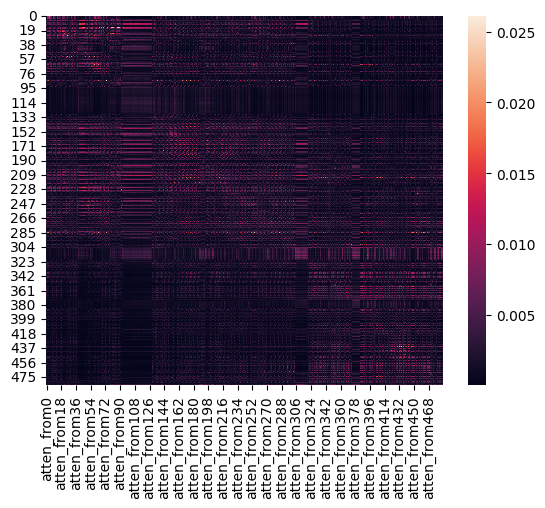

DevilsFoot:Mortimer, ranking [2]


,predicate,whom,subject,why,what,where
0,word.predicate:go,DevilsFoot:Brenda,DevilsFoot:Sterndale,DevilsFoot:Sterndale,DevilsFoot:Sterndale,ResidentPatient:Percy_Trevelyan
1,word.predicate:say,DevilsFoot:Mortimer,CrookedMan:Nancy,ResidentPatient:Blessington,SpeckledBand:Roylott,SpeckledBand:Roylott
2,word.predicate:enter,DevilsFoot:Sterndale,DevilsFoot:Mortimer,SpeckledBand:1883-04-01T14,AllTitle:Holmes,ResidentPatient:Blessington
3,bos_e,AllTitle:Holmes,DevilsFoot:Brenda,ACaseOfIdentity:380,ResidentPatient:Percy_Trevelyan,DevilsFoot:window
4,word.predicate:come,DevilsFoot:Owen,ResidentPatient:Blessington,SpeckledBand:mansion_of_Roylott,DevilsFoot:window,DevilsFoot:Sterndale
5,word.predicate:open,ACaseOfIdentity:Windibank,DevilsFoot:Roundhay,word.predicate:die,SilverBlaze:police,AllTitle:Holmes
6,word.predicate:exist,ResidentPatient:Blessington,AllTitle:Holmes,word.predicate:fall,word.predicate:open,SilverBlaze:police
7,DevilsFoot:Sterndale,ResidentPatient:Percy_Trevelyan,ACaseOfIdentity:Windibank,SpeckledBand:Helen_s_bedroom,ACaseOfIdentity:letter,DevilsFoot:cottage_of_Pordeux_Bay
8,word.predicate:kill,DevilsFoot:George,DancingMen:Cubitt,word.predicate:enter,bos_e,DevilsFoot:Roundhay
9,word.predicate:sit,CrookedMan:Nancy,DancingMen:Elsie,SpeckledBand:Roylott_s_bedroom,CrookedMan:Nancy,CrookedMan:Nancy


466

['DevilsFoot:439', 'kgc:subject', 'DevilsFoot:Mortimer']

,head,relation,tail,atten_from466
285,DevilsFoot:408,kgc:subject,DevilsFoot:Sterndale,0.016677
270,DevilsFoot:405,kgc:subject,DevilsFoot:Sterndale,0.014769
459,DevilsFoot:438,kgc:subject,DevilsFoot:Sterndale,0.013503
466,DevilsFoot:439,kgc:subject,DevilsFoot:Mortimer,0.012023
265,DevilsFoot:404,kgc:subject,DevilsFoot:Sterndale,0.011400
85,DevilsFoot:375,kgc:subject,DevilsFoot:Sterndale,0.010911
435,DevilsFoot:433,kgc:infoSource,DevilsFoot:Sterndale,0.010664
453,DevilsFoot:437,kgc:subject,DevilsFoot:Mortimer,0.010631
280,DevilsFoot:407,kgc:subject,DevilsFoot:Sterndale,0.010469
447,DevilsFoot:436,kgc:subject,DevilsFoot:Sterndale,0.010116


----------


467

['DevilsFoot:439', 'kgc:hasPredicate', 'word.predicate:come']

,head,relation,tail,atten_from467
272,DevilsFoot:405,kgc:what,DevilsFoot:room,0.009291
310,DevilsFoot:412,kgc:what,DevilsFoot:417,0.007093
317,DevilsFoot:412,kgc:what,DevilsFoot:424,0.007064
233,DevilsFoot:397,kgc:what,DevilsFoot:gravel,0.006791
319,DevilsFoot:412,kgc:what,DevilsFoot:426,0.006751
334,DevilsFoot:415,kgc:subject,DevilsFoot:Sterndale,0.006350
315,DevilsFoot:412,kgc:what,DevilsFoot:422,0.006233
311,DevilsFoot:412,kgc:what,DevilsFoot:418,0.006210
476,DevilsFoot:440,kgc:what,DevilsFoot:rare_object_of_Africa,0.006196
307,DevilsFoot:412,kgc:what,DevilsFoot:414,0.006065


----------


468

['DevilsFoot:439', 'kgc:to', 'DevilsFoot:cottage_of_Sterndale']

,head,relation,tail,atten_from468
461,DevilsFoot:438,kgc:whom,DevilsFoot:Owen,0.009555
466,DevilsFoot:439,kgc:subject,DevilsFoot:Mortimer,0.009400
462,DevilsFoot:438,kgc:whom,DevilsFoot:George,0.008155
481,mask_e,kgc:whom,DevilsFoot:Brenda,0.007948
456,DevilsFoot:437,kgc:whom,DevilsFoot:Brother,0.007896
273,DevilsFoot:405,kgc:infoSource,AllTitle:Holmes,0.007658
297,DevilsFoot:410,kgc:infoSource,AllTitle:Holmes,0.007057
468,DevilsFoot:439,kgc:to,DevilsFoot:cottage_of_Sterndale,0.007008
455,DevilsFoot:437,kgc:what,DevilsFoot:Good_friends,0.006774
453,DevilsFoot:437,kgc:subject,DevilsFoot:Mortimer,0.006547


----------


469

['DevilsFoot:439', 'kgc:infoSource', 'DevilsFoot:Sterndale']

,head,relation,tail,atten_from469
469,DevilsFoot:439,kgc:infoSource,DevilsFoot:Sterndale,0.013729
466,DevilsFoot:439,kgc:subject,DevilsFoot:Mortimer,0.013576
459,DevilsFoot:438,kgc:subject,DevilsFoot:Sterndale,0.013376
212,DevilsFoot:393,kgc:subject,DevilsFoot:Sterndale,0.012420
270,DevilsFoot:405,kgc:subject,DevilsFoot:Sterndale,0.012221
474,DevilsFoot:440,kgc:subject,DevilsFoot:Sterndale,0.012175
351,DevilsFoot:418,kgc:infoSource,DevilsFoot:Sterndale,0.010853
435,DevilsFoot:433,kgc:infoSource,DevilsFoot:Sterndale,0.010788
356,DevilsFoot:419,kgc:subject,DevilsFoot:Sterndale,0.010051
358,DevilsFoot:419,kgc:infoSource,DevilsFoot:Sterndale,0.009938


----------


470

['DevilsFoot:439', 'kgc:when', 'DevilsFoot:2_weeks_ago']

,head,relation,tail,atten_from470
272,DevilsFoot:405,kgc:what,DevilsFoot:room,0.013221
310,DevilsFoot:412,kgc:what,DevilsFoot:417,0.008897
472,DevilsFoot:439,kgc:time,DateTime:1896-03-02T00:00:00,0.008091
351,DevilsFoot:418,kgc:infoSource,DevilsFoot:Sterndale,0.007858
469,DevilsFoot:439,kgc:infoSource,DevilsFoot:Sterndale,0.007746
300,DevilsFoot:411,kgc:subject,DevilsFoot:Mortimer,0.007038
476,DevilsFoot:440,kgc:what,DevilsFoot:rare_object_of_Africa,0.006854
435,DevilsFoot:433,kgc:infoSource,DevilsFoot:Sterndale,0.006805
319,DevilsFoot:412,kgc:what,DevilsFoot:426,0.006772
369,DevilsFoot:421,kgc:what,DevilsFoot:marriage,0.006666


----------


471

['DevilsFoot:439', 'kgc:when', 'DevilsFoot:1896-03-02']

,head,relation,tail,atten_from471
272,DevilsFoot:405,kgc:what,DevilsFoot:room,0.013734
472,DevilsFoot:439,kgc:time,DateTime:1896-03-02T00:00:00,0.009175
310,DevilsFoot:412,kgc:what,DevilsFoot:417,0.008932
319,DevilsFoot:412,kgc:what,DevilsFoot:426,0.007372
369,DevilsFoot:421,kgc:what,DevilsFoot:marriage,0.007217
317,DevilsFoot:412,kgc:what,DevilsFoot:424,0.007136
484,mask_e,kgc:what,mask_e,0.006781
469,DevilsFoot:439,kgc:infoSource,DevilsFoot:Sterndale,0.006476
351,DevilsFoot:418,kgc:infoSource,DevilsFoot:Sterndale,0.006429
311,DevilsFoot:412,kgc:what,DevilsFoot:418,0.006399


----------


472

['DevilsFoot:439', 'kgc:time', 'DateTime:1896-03-02T00:00:00']

,head,relation,tail,atten_from472
469,DevilsFoot:439,kgc:infoSource,DevilsFoot:Sterndale,0.012012
351,DevilsFoot:418,kgc:infoSource,DevilsFoot:Sterndale,0.011068
192,DevilsFoot:388,kgc:time,DateTime:1896-03-18T05:00:00,0.009938
472,DevilsFoot:439,kgc:time,DateTime:1896-03-02T00:00:00,0.009756
435,DevilsFoot:433,kgc:infoSource,DevilsFoot:Sterndale,0.009343
354,DevilsFoot:418,kgc:time,DateTime:1890-04-01T00:00:00,0.008529
358,DevilsFoot:419,kgc:infoSource,DevilsFoot:Sterndale,0.008434
370,DevilsFoot:421,kgc:infoSource,DevilsFoot:Sterndale,0.008182
310,DevilsFoot:412,kgc:what,DevilsFoot:417,0.008016
272,DevilsFoot:405,kgc:what,DevilsFoot:room,0.007318


----------


473

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from473
272,DevilsFoot:405,kgc:what,DevilsFoot:room,0.006313
47,bos_e,bos_r,bos_e,0.006100
37,bos_e,bos_r,bos_e,0.005299
52,bos_e,bos_r,bos_e,0.005145
33,bos_e,bos_r,bos_e,0.005135
350,DevilsFoot:418,kgc:hasPredicate,word.predicate:leave,0.005119
91,bos_e,bos_r,bos_e,0.005033
372,bos_e,bos_r,bos_e,0.004992
209,DevilsFoot:392,kgc:hasPredicate,word.predicate:exist,0.004954
423,bos_e,bos_r,bos_e,0.004952


----------


474

['DevilsFoot:440', 'kgc:subject', 'DevilsFoot:Sterndale']

,head,relation,tail,atten_from474
212,DevilsFoot:393,kgc:subject,DevilsFoot:Sterndale,0.016047
270,DevilsFoot:405,kgc:subject,DevilsFoot:Sterndale,0.013897
474,DevilsFoot:440,kgc:subject,DevilsFoot:Sterndale,0.013069
285,DevilsFoot:408,kgc:subject,DevilsFoot:Sterndale,0.012763
351,DevilsFoot:418,kgc:infoSource,DevilsFoot:Sterndale,0.012464
85,DevilsFoot:375,kgc:subject,DevilsFoot:Sterndale,0.012454
435,DevilsFoot:433,kgc:infoSource,DevilsFoot:Sterndale,0.011473
407,DevilsFoot:427,kgc:subject,DevilsFoot:Sterndale,0.010894
356,DevilsFoot:419,kgc:subject,DevilsFoot:Sterndale,0.010766
409,DevilsFoot:427,kgc:infoSource,DevilsFoot:Sterndale,0.010202


----------


475

['DevilsFoot:440', 'kgc:hasPredicate', 'word.predicate:show']

,head,relation,tail,atten_from475
310,DevilsFoot:412,kgc:what,DevilsFoot:417,0.010626
317,DevilsFoot:412,kgc:what,DevilsFoot:424,0.010093
315,DevilsFoot:412,kgc:what,DevilsFoot:422,0.009958
307,DevilsFoot:412,kgc:what,DevilsFoot:414,0.009026
280,DevilsFoot:407,kgc:subject,DevilsFoot:Sterndale,0.008836
306,DevilsFoot:412,kgc:what,DevilsFoot:413,0.008464
309,DevilsFoot:412,kgc:what,DevilsFoot:416,0.008442
308,DevilsFoot:412,kgc:what,DevilsFoot:415,0.008305
311,DevilsFoot:412,kgc:what,DevilsFoot:418,0.008254
319,DevilsFoot:412,kgc:what,DevilsFoot:426,0.008188


----------


476

['DevilsFoot:440', 'kgc:what', 'DevilsFoot:rare_object_of_Africa']

,head,relation,tail,atten_from476
310,DevilsFoot:412,kgc:what,DevilsFoot:417,0.010171
317,DevilsFoot:412,kgc:what,DevilsFoot:424,0.007816
435,DevilsFoot:433,kgc:infoSource,DevilsFoot:Sterndale,0.007507
315,DevilsFoot:412,kgc:what,DevilsFoot:422,0.007238
351,DevilsFoot:418,kgc:infoSource,DevilsFoot:Sterndale,0.007175
369,DevilsFoot:421,kgc:what,DevilsFoot:marriage,0.007174
484,mask_e,kgc:what,mask_e,0.006625
311,DevilsFoot:412,kgc:what,DevilsFoot:418,0.006536
312,DevilsFoot:412,kgc:what,DevilsFoot:419,0.006508
319,DevilsFoot:412,kgc:what,DevilsFoot:426,0.006442


----------


477

['DevilsFoot:440', 'kgc:infoSource', 'DevilsFoot:Sterndale']

,head,relation,tail,atten_from477
212,DevilsFoot:393,kgc:subject,DevilsFoot:Sterndale,0.017636
474,DevilsFoot:440,kgc:subject,DevilsFoot:Sterndale,0.012115
161,DevilsFoot:383,kgc:subject,DevilsFoot:Sterndale,0.011564
270,DevilsFoot:405,kgc:subject,DevilsFoot:Sterndale,0.011026
166,DevilsFoot:384,kgc:subject,DevilsFoot:Sterndale,0.010730
407,DevilsFoot:427,kgc:subject,DevilsFoot:Sterndale,0.010314
409,DevilsFoot:427,kgc:infoSource,DevilsFoot:Sterndale,0.010180
300,DevilsFoot:411,kgc:subject,DevilsFoot:Mortimer,0.010097
459,DevilsFoot:438,kgc:subject,DevilsFoot:Sterndale,0.009935
435,DevilsFoot:433,kgc:infoSource,DevilsFoot:Sterndale,0.009931


----------


478

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from478
47,bos_e,bos_r,bos_e,0.006191
272,DevilsFoot:405,kgc:what,DevilsFoot:room,0.005672
350,DevilsFoot:418,kgc:hasPredicate,word.predicate:leave,0.005402
37,bos_e,bos_r,bos_e,0.005324
209,DevilsFoot:392,kgc:hasPredicate,word.predicate:exist,0.005271
52,bos_e,bos_r,bos_e,0.005209
33,bos_e,bos_r,bos_e,0.005151
91,bos_e,bos_r,bos_e,0.005108
372,bos_e,bos_r,bos_e,0.004993
423,bos_e,bos_r,bos_e,0.004924


----------


479

['mask_e', 'kgc:infoSource', 'AllTitle:Holmes']

,head,relation,tail,atten_from479
370,DevilsFoot:421,kgc:infoSource,DevilsFoot:Sterndale,0.011206
300,DevilsFoot:411,kgc:subject,DevilsFoot:Mortimer,0.010474
358,DevilsFoot:419,kgc:infoSource,DevilsFoot:Sterndale,0.010405
435,DevilsFoot:433,kgc:infoSource,DevilsFoot:Sterndale,0.009791
464,DevilsFoot:438,kgc:infoSource,DevilsFoot:Sterndale,0.009588
469,DevilsFoot:439,kgc:infoSource,DevilsFoot:Sterndale,0.009308
457,DevilsFoot:437,kgc:infoSource,DevilsFoot:Sterndale,0.009268
364,DevilsFoot:420,kgc:infoSource,DevilsFoot:Sterndale,0.008846
409,DevilsFoot:427,kgc:infoSource,DevilsFoot:Sterndale,0.008836
273,DevilsFoot:405,kgc:infoSource,AllTitle:Holmes,0.008581


----------


480

['mask_e', 'kgc:hasPredicate', 'word.predicate:kill']

,head,relation,tail,atten_from480
315,DevilsFoot:412,kgc:what,DevilsFoot:422,0.010786
317,DevilsFoot:412,kgc:what,DevilsFoot:424,0.009401
311,DevilsFoot:412,kgc:what,DevilsFoot:418,0.009350
309,DevilsFoot:412,kgc:what,DevilsFoot:416,0.009150
280,DevilsFoot:407,kgc:subject,DevilsFoot:Sterndale,0.008842
307,DevilsFoot:412,kgc:what,DevilsFoot:414,0.008732
310,DevilsFoot:412,kgc:what,DevilsFoot:417,0.008585
304,DevilsFoot:412,kgc:subject,DevilsFoot:Sterndale,0.008579
306,DevilsFoot:412,kgc:what,DevilsFoot:413,0.008196
312,DevilsFoot:412,kgc:what,DevilsFoot:419,0.007638


----------


481

['mask_e', 'kgc:whom', 'DevilsFoot:Brenda']

,head,relation,tail,atten_from481
370,DevilsFoot:421,kgc:infoSource,DevilsFoot:Sterndale,0.014636
285,DevilsFoot:408,kgc:subject,DevilsFoot:Sterndale,0.014625
304,DevilsFoot:412,kgc:subject,DevilsFoot:Sterndale,0.013910
358,DevilsFoot:419,kgc:infoSource,DevilsFoot:Sterndale,0.013208
367,DevilsFoot:421,kgc:subject,DevilsFoot:Sterndale,0.012732
322,DevilsFoot:413,kgc:subject,DevilsFoot:Sterndale,0.012664
364,DevilsFoot:420,kgc:infoSource,DevilsFoot:Sterndale,0.012152
351,DevilsFoot:418,kgc:infoSource,DevilsFoot:Sterndale,0.011834
85,DevilsFoot:375,kgc:subject,DevilsFoot:Sterndale,0.011686
325,DevilsFoot:413,kgc:infoSource,DevilsFoot:Sterndale,0.011523


----------


482

['mask_e', 'kgc:subject', 'mask_e']

,head,relation,tail,atten_from482
285,DevilsFoot:408,kgc:subject,DevilsFoot:Sterndale,0.014980
370,DevilsFoot:421,kgc:infoSource,DevilsFoot:Sterndale,0.014200
270,DevilsFoot:405,kgc:subject,DevilsFoot:Sterndale,0.013471
212,DevilsFoot:393,kgc:subject,DevilsFoot:Sterndale,0.013016
358,DevilsFoot:419,kgc:infoSource,DevilsFoot:Sterndale,0.012606
85,DevilsFoot:375,kgc:subject,DevilsFoot:Sterndale,0.012454
322,DevilsFoot:413,kgc:subject,DevilsFoot:Sterndale,0.011386
351,DevilsFoot:418,kgc:infoSource,DevilsFoot:Sterndale,0.011283
364,DevilsFoot:420,kgc:infoSource,DevilsFoot:Sterndale,0.011081
280,DevilsFoot:407,kgc:subject,DevilsFoot:Sterndale,0.010912


----------


483

['mask_e', 'kgc:why', 'mask_e']

,head,relation,tail,atten_from483
310,DevilsFoot:412,kgc:what,DevilsFoot:417,0.009393
205,DevilsFoot:391,kgc:to,DevilsFoot:pocket,0.007484
312,DevilsFoot:412,kgc:what,DevilsFoot:419,0.007200
200,DevilsFoot:390,kgc:time,DateTime:1896-03-18T06:00:00,0.007195
267,DevilsFoot:404,kgc:infoSource,AllTitle:Holmes,0.006507
178,DevilsFoot:386,kgc:where,DevilsFoot:Cottage,0.006446
311,DevilsFoot:412,kgc:what,DevilsFoot:418,0.006339
351,DevilsFoot:418,kgc:infoSource,DevilsFoot:Sterndale,0.006111
306,DevilsFoot:412,kgc:what,DevilsFoot:413,0.005775
330,DevilsFoot:414,kgc:what,DevilsFoot:Sterndale,0.005770


----------


484

['mask_e', 'kgc:what', 'mask_e']

,head,relation,tail,atten_from484
310,DevilsFoot:412,kgc:what,DevilsFoot:417,0.013308
267,DevilsFoot:404,kgc:infoSource,AllTitle:Holmes,0.010136
312,DevilsFoot:412,kgc:what,DevilsFoot:419,0.009286
273,DevilsFoot:405,kgc:infoSource,AllTitle:Holmes,0.009281
317,DevilsFoot:412,kgc:what,DevilsFoot:424,0.008853
311,DevilsFoot:412,kgc:what,DevilsFoot:418,0.008611
315,DevilsFoot:412,kgc:what,DevilsFoot:422,0.008415
210,DevilsFoot:392,kgc:infoSource,AllTitle:Holmes,0.008132
306,DevilsFoot:412,kgc:what,DevilsFoot:413,0.008015
314,DevilsFoot:412,kgc:what,DevilsFoot:421,0.007789


----------


485

['mask_e', 'kgc:where', 'mask_e']

,head,relation,tail,atten_from485
310,DevilsFoot:412,kgc:what,DevilsFoot:417,0.011375
351,DevilsFoot:418,kgc:infoSource,DevilsFoot:Sterndale,0.009942
267,DevilsFoot:404,kgc:infoSource,AllTitle:Holmes,0.009923
312,DevilsFoot:412,kgc:what,DevilsFoot:419,0.009093
435,DevilsFoot:433,kgc:infoSource,DevilsFoot:Sterndale,0.008754
273,DevilsFoot:405,kgc:infoSource,AllTitle:Holmes,0.008722
210,DevilsFoot:392,kgc:infoSource,AllTitle:Holmes,0.008175
311,DevilsFoot:412,kgc:what,DevilsFoot:418,0.008033
315,DevilsFoot:412,kgc:what,DevilsFoot:422,0.007556
358,DevilsFoot:419,kgc:infoSource,DevilsFoot:Sterndale,0.007311


----------


In [15]:
title = 'DevilsFoot'
victim_name = 'Brenda'
killer_name = 'Mortimer'
last_index = 440
story_len = 80

df_ranking_SpeckledBand, df_attension_SpeckledBand = main_func01(title, victim_name, killer_name, last_index, story_len)

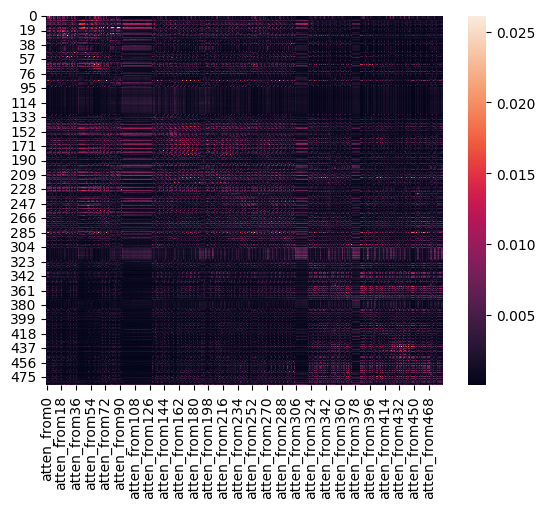

DevilsFoot:Sterndale, ranking [0]


,predicate,whom,subject,why,what,where
0,word.predicate:go,DevilsFoot:Mortimer,DevilsFoot:Sterndale,DevilsFoot:Sterndale,DevilsFoot:Sterndale,ResidentPatient:Percy_Trevelyan
1,word.predicate:enter,AllTitle:Holmes,CrookedMan:Nancy,SpeckledBand:1883-04-01T14,SpeckledBand:Roylott,SpeckledBand:Roylott
2,bos_e,DevilsFoot:Sterndale,DevilsFoot:Mortimer,ResidentPatient:Blessington,DevilsFoot:window,DevilsFoot:window
3,word.predicate:say,ACaseOfIdentity:Windibank,DevilsFoot:Brenda,ACaseOfIdentity:380,AllTitle:Holmes,ResidentPatient:Blessington
4,word.predicate:come,DevilsFoot:Brenda,DevilsFoot:Roundhay,SilverBlaze:Wife_of_John_Straker,SilverBlaze:police,SilverBlaze:police
5,word.predicate:open,ResidentPatient:Blessington,ResidentPatient:Blessington,SpeckledBand:mansion_of_Roylott,word.predicate:open,AllTitle:Holmes
6,word.predicate:exist,ResidentPatient:Percy_Trevelyan,AbbeyGrange:Jack_Croker,word.predicate:want,ResidentPatient:Percy_Trevelyan,DevilsFoot:Sterndale
7,DevilsFoot:Sterndale,DevilsFoot:Roundhay,AllTitle:Holmes,SilverBlaze:police,word.predicate:return,DevilsFoot:cottage_of_Pordeux_Bay
8,word.predicate:kill,DevilsFoot:Owen,ACaseOfIdentity:Windibank,word.predicate:live,bos_e,DevilsFoot:Roundhay
9,word.predicate:sit,CrookedMan:Nancy,DancingMen:Cubitt,SpeckledBand:Roylott_s_bedroom,DancingMen:Cubitt,CrookedMan:Nancy


466

['DevilsFoot:439', 'kgc:subject', 'DevilsFoot:Mortimer']

,head,relation,tail,atten_from466
285,DevilsFoot:408,kgc:subject,DevilsFoot:Sterndale,0.016667
270,DevilsFoot:405,kgc:subject,DevilsFoot:Sterndale,0.014931
459,DevilsFoot:438,kgc:subject,DevilsFoot:Sterndale,0.013767
466,DevilsFoot:439,kgc:subject,DevilsFoot:Mortimer,0.012482
265,DevilsFoot:404,kgc:subject,DevilsFoot:Sterndale,0.011511
453,DevilsFoot:437,kgc:subject,DevilsFoot:Mortimer,0.010963
85,DevilsFoot:375,kgc:subject,DevilsFoot:Sterndale,0.010829
280,DevilsFoot:407,kgc:subject,DevilsFoot:Sterndale,0.010698
435,DevilsFoot:433,kgc:infoSource,DevilsFoot:Sterndale,0.010688
447,DevilsFoot:436,kgc:subject,DevilsFoot:Sterndale,0.010293


----------


467

['DevilsFoot:439', 'kgc:hasPredicate', 'word.predicate:come']

,head,relation,tail,atten_from467
272,DevilsFoot:405,kgc:what,DevilsFoot:room,0.009535
233,DevilsFoot:397,kgc:what,DevilsFoot:gravel,0.007056
317,DevilsFoot:412,kgc:what,DevilsFoot:424,0.006845
310,DevilsFoot:412,kgc:what,DevilsFoot:417,0.006835
319,DevilsFoot:412,kgc:what,DevilsFoot:426,0.006493
334,DevilsFoot:415,kgc:subject,DevilsFoot:Sterndale,0.006315
476,DevilsFoot:440,kgc:what,DevilsFoot:rare_object_of_Africa,0.006097
311,DevilsFoot:412,kgc:what,DevilsFoot:418,0.006050
280,DevilsFoot:407,kgc:subject,DevilsFoot:Sterndale,0.005996
315,DevilsFoot:412,kgc:what,DevilsFoot:422,0.005979


----------


468

['DevilsFoot:439', 'kgc:to', 'DevilsFoot:cottage_of_Sterndale']

,head,relation,tail,atten_from468
461,DevilsFoot:438,kgc:whom,DevilsFoot:Owen,0.009571
466,DevilsFoot:439,kgc:subject,DevilsFoot:Mortimer,0.009566
462,DevilsFoot:438,kgc:whom,DevilsFoot:George,0.008236
456,DevilsFoot:437,kgc:whom,DevilsFoot:Brother,0.007862
273,DevilsFoot:405,kgc:infoSource,AllTitle:Holmes,0.007714
297,DevilsFoot:410,kgc:infoSource,AllTitle:Holmes,0.006876
468,DevilsFoot:439,kgc:to,DevilsFoot:cottage_of_Sterndale,0.006773
455,DevilsFoot:437,kgc:what,DevilsFoot:Good_friends,0.006713
272,DevilsFoot:405,kgc:what,DevilsFoot:room,0.006665
453,DevilsFoot:437,kgc:subject,DevilsFoot:Mortimer,0.006659


----------


469

['DevilsFoot:439', 'kgc:infoSource', 'DevilsFoot:Sterndale']

,head,relation,tail,atten_from469
469,DevilsFoot:439,kgc:infoSource,DevilsFoot:Sterndale,0.014342
466,DevilsFoot:439,kgc:subject,DevilsFoot:Mortimer,0.014050
459,DevilsFoot:438,kgc:subject,DevilsFoot:Sterndale,0.013603
212,DevilsFoot:393,kgc:subject,DevilsFoot:Sterndale,0.012536
474,DevilsFoot:440,kgc:subject,DevilsFoot:Sterndale,0.012532
270,DevilsFoot:405,kgc:subject,DevilsFoot:Sterndale,0.012349
435,DevilsFoot:433,kgc:infoSource,DevilsFoot:Sterndale,0.010907
351,DevilsFoot:418,kgc:infoSource,DevilsFoot:Sterndale,0.010831
356,DevilsFoot:419,kgc:subject,DevilsFoot:Sterndale,0.010014
358,DevilsFoot:419,kgc:infoSource,DevilsFoot:Sterndale,0.009852


----------


470

['DevilsFoot:439', 'kgc:when', 'DevilsFoot:2_weeks_ago']

,head,relation,tail,atten_from470
272,DevilsFoot:405,kgc:what,DevilsFoot:room,0.013522
310,DevilsFoot:412,kgc:what,DevilsFoot:417,0.008492
469,DevilsFoot:439,kgc:infoSource,DevilsFoot:Sterndale,0.007812
472,DevilsFoot:439,kgc:time,DateTime:1896-03-02T00:00:00,0.007807
351,DevilsFoot:418,kgc:infoSource,DevilsFoot:Sterndale,0.007769
435,DevilsFoot:433,kgc:infoSource,DevilsFoot:Sterndale,0.006871
300,DevilsFoot:411,kgc:subject,DevilsFoot:Mortimer,0.006682
319,DevilsFoot:412,kgc:what,DevilsFoot:426,0.006438
476,DevilsFoot:440,kgc:what,DevilsFoot:rare_object_of_Africa,0.006333
317,DevilsFoot:412,kgc:what,DevilsFoot:424,0.006136


----------


471

['DevilsFoot:439', 'kgc:when', 'DevilsFoot:1896-03-02']

,head,relation,tail,atten_from471
272,DevilsFoot:405,kgc:what,DevilsFoot:room,0.014217
472,DevilsFoot:439,kgc:time,DateTime:1896-03-02T00:00:00,0.009020
310,DevilsFoot:412,kgc:what,DevilsFoot:417,0.008398
319,DevilsFoot:412,kgc:what,DevilsFoot:426,0.006925
317,DevilsFoot:412,kgc:what,DevilsFoot:424,0.006730
469,DevilsFoot:439,kgc:infoSource,DevilsFoot:Sterndale,0.006559
369,DevilsFoot:421,kgc:what,DevilsFoot:marriage,0.006495
351,DevilsFoot:418,kgc:infoSource,DevilsFoot:Sterndale,0.006416
311,DevilsFoot:412,kgc:what,DevilsFoot:418,0.006041
484,mask_e,kgc:what,mask_e,0.005978


----------


472

['DevilsFoot:439', 'kgc:time', 'DateTime:1896-03-02T00:00:00']

,head,relation,tail,atten_from472
469,DevilsFoot:439,kgc:infoSource,DevilsFoot:Sterndale,0.012118
351,DevilsFoot:418,kgc:infoSource,DevilsFoot:Sterndale,0.011102
435,DevilsFoot:433,kgc:infoSource,DevilsFoot:Sterndale,0.009294
192,DevilsFoot:388,kgc:time,DateTime:1896-03-18T05:00:00,0.009108
472,DevilsFoot:439,kgc:time,DateTime:1896-03-02T00:00:00,0.008989
358,DevilsFoot:419,kgc:infoSource,DevilsFoot:Sterndale,0.008365
370,DevilsFoot:421,kgc:infoSource,DevilsFoot:Sterndale,0.008035
354,DevilsFoot:418,kgc:time,DateTime:1890-04-01T00:00:00,0.008026
310,DevilsFoot:412,kgc:what,DevilsFoot:417,0.007697
272,DevilsFoot:405,kgc:what,DevilsFoot:room,0.007641


----------


473

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from473
272,DevilsFoot:405,kgc:what,DevilsFoot:room,0.006343
47,bos_e,bos_r,bos_e,0.006105
37,bos_e,bos_r,bos_e,0.005303
350,DevilsFoot:418,kgc:hasPredicate,word.predicate:leave,0.005157
52,bos_e,bos_r,bos_e,0.005144
33,bos_e,bos_r,bos_e,0.005138
91,bos_e,bos_r,bos_e,0.005032
209,DevilsFoot:392,kgc:hasPredicate,word.predicate:exist,0.004998
372,bos_e,bos_r,bos_e,0.004993
423,bos_e,bos_r,bos_e,0.004958


----------


474

['DevilsFoot:440', 'kgc:subject', 'DevilsFoot:Sterndale']

,head,relation,tail,atten_from474
212,DevilsFoot:393,kgc:subject,DevilsFoot:Sterndale,0.016347
270,DevilsFoot:405,kgc:subject,DevilsFoot:Sterndale,0.014187
474,DevilsFoot:440,kgc:subject,DevilsFoot:Sterndale,0.013352
285,DevilsFoot:408,kgc:subject,DevilsFoot:Sterndale,0.012827
351,DevilsFoot:418,kgc:infoSource,DevilsFoot:Sterndale,0.012504
85,DevilsFoot:375,kgc:subject,DevilsFoot:Sterndale,0.012428
435,DevilsFoot:433,kgc:infoSource,DevilsFoot:Sterndale,0.011652
407,DevilsFoot:427,kgc:subject,DevilsFoot:Sterndale,0.010970
356,DevilsFoot:419,kgc:subject,DevilsFoot:Sterndale,0.010682
469,DevilsFoot:439,kgc:infoSource,DevilsFoot:Sterndale,0.010327


----------


475

['DevilsFoot:440', 'kgc:hasPredicate', 'word.predicate:show']

,head,relation,tail,atten_from475
310,DevilsFoot:412,kgc:what,DevilsFoot:417,0.010247
317,DevilsFoot:412,kgc:what,DevilsFoot:424,0.009774
315,DevilsFoot:412,kgc:what,DevilsFoot:422,0.009498
280,DevilsFoot:407,kgc:subject,DevilsFoot:Sterndale,0.008970
307,DevilsFoot:412,kgc:what,DevilsFoot:414,0.008621
306,DevilsFoot:412,kgc:what,DevilsFoot:413,0.008149
308,DevilsFoot:412,kgc:what,DevilsFoot:415,0.008123
309,DevilsFoot:412,kgc:what,DevilsFoot:416,0.008067
311,DevilsFoot:412,kgc:what,DevilsFoot:418,0.007960
272,DevilsFoot:405,kgc:what,DevilsFoot:room,0.007897


----------


476

['DevilsFoot:440', 'kgc:what', 'DevilsFoot:rare_object_of_Africa']

,head,relation,tail,atten_from476
310,DevilsFoot:412,kgc:what,DevilsFoot:417,0.009868
435,DevilsFoot:433,kgc:infoSource,DevilsFoot:Sterndale,0.007705
317,DevilsFoot:412,kgc:what,DevilsFoot:424,0.007606
351,DevilsFoot:418,kgc:infoSource,DevilsFoot:Sterndale,0.007327
315,DevilsFoot:412,kgc:what,DevilsFoot:422,0.006971
369,DevilsFoot:421,kgc:what,DevilsFoot:marriage,0.006680
272,DevilsFoot:405,kgc:what,DevilsFoot:room,0.006493
370,DevilsFoot:421,kgc:infoSource,DevilsFoot:Sterndale,0.006354
311,DevilsFoot:412,kgc:what,DevilsFoot:418,0.006333
210,DevilsFoot:392,kgc:infoSource,AllTitle:Holmes,0.006296


----------


477

['DevilsFoot:440', 'kgc:infoSource', 'DevilsFoot:Sterndale']

,head,relation,tail,atten_from477
212,DevilsFoot:393,kgc:subject,DevilsFoot:Sterndale,0.017695
474,DevilsFoot:440,kgc:subject,DevilsFoot:Sterndale,0.012320
161,DevilsFoot:383,kgc:subject,DevilsFoot:Sterndale,0.011469
270,DevilsFoot:405,kgc:subject,DevilsFoot:Sterndale,0.011244
166,DevilsFoot:384,kgc:subject,DevilsFoot:Sterndale,0.010682
407,DevilsFoot:427,kgc:subject,DevilsFoot:Sterndale,0.010329
409,DevilsFoot:427,kgc:infoSource,DevilsFoot:Sterndale,0.010199
469,DevilsFoot:439,kgc:infoSource,DevilsFoot:Sterndale,0.010173
435,DevilsFoot:433,kgc:infoSource,DevilsFoot:Sterndale,0.010087
459,DevilsFoot:438,kgc:subject,DevilsFoot:Sterndale,0.009985


----------


478

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from478
47,bos_e,bos_r,bos_e,0.006210
272,DevilsFoot:405,kgc:what,DevilsFoot:room,0.005683
350,DevilsFoot:418,kgc:hasPredicate,word.predicate:leave,0.005480
209,DevilsFoot:392,kgc:hasPredicate,word.predicate:exist,0.005346
37,bos_e,bos_r,bos_e,0.005341
52,bos_e,bos_r,bos_e,0.005220
33,bos_e,bos_r,bos_e,0.005168
91,bos_e,bos_r,bos_e,0.005121
372,bos_e,bos_r,bos_e,0.005005
423,bos_e,bos_r,bos_e,0.004944


----------


479

['mask_e', 'kgc:infoSource', 'AllTitle:Holmes']

,head,relation,tail,atten_from479
370,DevilsFoot:421,kgc:infoSource,DevilsFoot:Sterndale,0.010790
358,DevilsFoot:419,kgc:infoSource,DevilsFoot:Sterndale,0.010208
435,DevilsFoot:433,kgc:infoSource,DevilsFoot:Sterndale,0.010187
300,DevilsFoot:411,kgc:subject,DevilsFoot:Mortimer,0.009989
464,DevilsFoot:438,kgc:infoSource,DevilsFoot:Sterndale,0.009888
469,DevilsFoot:439,kgc:infoSource,DevilsFoot:Sterndale,0.009536
457,DevilsFoot:437,kgc:infoSource,DevilsFoot:Sterndale,0.009493
364,DevilsFoot:420,kgc:infoSource,DevilsFoot:Sterndale,0.008677
409,DevilsFoot:427,kgc:infoSource,DevilsFoot:Sterndale,0.008628
351,DevilsFoot:418,kgc:infoSource,DevilsFoot:Sterndale,0.008540


----------


480

['mask_e', 'kgc:hasPredicate', 'word.predicate:kill']

,head,relation,tail,atten_from480
315,DevilsFoot:412,kgc:what,DevilsFoot:422,0.010205
311,DevilsFoot:412,kgc:what,DevilsFoot:418,0.009140
280,DevilsFoot:407,kgc:subject,DevilsFoot:Sterndale,0.008966
317,DevilsFoot:412,kgc:what,DevilsFoot:424,0.008859
304,DevilsFoot:412,kgc:subject,DevilsFoot:Sterndale,0.008544
309,DevilsFoot:412,kgc:what,DevilsFoot:416,0.008494
307,DevilsFoot:412,kgc:what,DevilsFoot:414,0.007950
310,DevilsFoot:412,kgc:what,DevilsFoot:417,0.007933
306,DevilsFoot:412,kgc:what,DevilsFoot:413,0.007459
312,DevilsFoot:412,kgc:what,DevilsFoot:419,0.007378


----------


481

['mask_e', 'kgc:whom', 'DevilsFoot:Mortimer']

,head,relation,tail,atten_from481
304,DevilsFoot:412,kgc:subject,DevilsFoot:Sterndale,0.012511
370,DevilsFoot:421,kgc:infoSource,DevilsFoot:Sterndale,0.012178
358,DevilsFoot:419,kgc:infoSource,DevilsFoot:Sterndale,0.011149
285,DevilsFoot:408,kgc:subject,DevilsFoot:Sterndale,0.010874
325,DevilsFoot:413,kgc:infoSource,DevilsFoot:Sterndale,0.010867
300,DevilsFoot:411,kgc:subject,DevilsFoot:Mortimer,0.010409
364,DevilsFoot:420,kgc:infoSource,DevilsFoot:Sterndale,0.010325
322,DevilsFoot:413,kgc:subject,DevilsFoot:Sterndale,0.010249
435,DevilsFoot:433,kgc:infoSource,DevilsFoot:Sterndale,0.010245
351,DevilsFoot:418,kgc:infoSource,DevilsFoot:Sterndale,0.009910


----------


482

['mask_e', 'kgc:subject', 'mask_e']

,head,relation,tail,atten_from482
285,DevilsFoot:408,kgc:subject,DevilsFoot:Sterndale,0.013958
270,DevilsFoot:405,kgc:subject,DevilsFoot:Sterndale,0.013713
212,DevilsFoot:393,kgc:subject,DevilsFoot:Sterndale,0.013000
370,DevilsFoot:421,kgc:infoSource,DevilsFoot:Sterndale,0.012911
358,DevilsFoot:419,kgc:infoSource,DevilsFoot:Sterndale,0.012155
280,DevilsFoot:407,kgc:subject,DevilsFoot:Sterndale,0.011893
85,DevilsFoot:375,kgc:subject,DevilsFoot:Sterndale,0.011242
351,DevilsFoot:418,kgc:infoSource,DevilsFoot:Sterndale,0.011027
322,DevilsFoot:413,kgc:subject,DevilsFoot:Sterndale,0.010817
364,DevilsFoot:420,kgc:infoSource,DevilsFoot:Sterndale,0.010539


----------


483

['mask_e', 'kgc:why', 'mask_e']

,head,relation,tail,atten_from483
310,DevilsFoot:412,kgc:what,DevilsFoot:417,0.008664
200,DevilsFoot:390,kgc:time,DateTime:1896-03-18T06:00:00,0.007578
205,DevilsFoot:391,kgc:to,DevilsFoot:pocket,0.007493
267,DevilsFoot:404,kgc:infoSource,AllTitle:Holmes,0.006992
312,DevilsFoot:412,kgc:what,DevilsFoot:419,0.006632
351,DevilsFoot:418,kgc:infoSource,DevilsFoot:Sterndale,0.006246
178,DevilsFoot:386,kgc:where,DevilsFoot:Cottage,0.005959
311,DevilsFoot:412,kgc:what,DevilsFoot:418,0.005862
210,DevilsFoot:392,kgc:infoSource,AllTitle:Holmes,0.005803
435,DevilsFoot:433,kgc:infoSource,DevilsFoot:Sterndale,0.005552


----------


484

['mask_e', 'kgc:what', 'mask_e']

,head,relation,tail,atten_from484
310,DevilsFoot:412,kgc:what,DevilsFoot:417,0.011728
267,DevilsFoot:404,kgc:infoSource,AllTitle:Holmes,0.010359
273,DevilsFoot:405,kgc:infoSource,AllTitle:Holmes,0.009168
312,DevilsFoot:412,kgc:what,DevilsFoot:419,0.008504
210,DevilsFoot:392,kgc:infoSource,AllTitle:Holmes,0.008357
317,DevilsFoot:412,kgc:what,DevilsFoot:424,0.008177
311,DevilsFoot:412,kgc:what,DevilsFoot:418,0.007935
315,DevilsFoot:412,kgc:what,DevilsFoot:422,0.007758
306,DevilsFoot:412,kgc:what,DevilsFoot:413,0.007467
314,DevilsFoot:412,kgc:what,DevilsFoot:421,0.007271


----------


485

['mask_e', 'kgc:where', 'mask_e']

,head,relation,tail,atten_from485
267,DevilsFoot:404,kgc:infoSource,AllTitle:Holmes,0.010450
310,DevilsFoot:412,kgc:what,DevilsFoot:417,0.010443
351,DevilsFoot:418,kgc:infoSource,DevilsFoot:Sterndale,0.009762
210,DevilsFoot:392,kgc:infoSource,AllTitle:Holmes,0.008927
435,DevilsFoot:433,kgc:infoSource,DevilsFoot:Sterndale,0.008746
273,DevilsFoot:405,kgc:infoSource,AllTitle:Holmes,0.008653
312,DevilsFoot:412,kgc:what,DevilsFoot:419,0.008428
311,DevilsFoot:412,kgc:what,DevilsFoot:418,0.007516
430,DevilsFoot:432,kgc:infoSource,DevilsFoot:Sterndale,0.007284
270,DevilsFoot:405,kgc:subject,DevilsFoot:Sterndale,0.007150


----------


In [17]:
title = 'DevilsFoot'
victim_name = 'Mortimer'
killer_name = 'Sterndale'
last_index = 440
story_len = 80
df_ranking_DevilsFoot2, df_attension_DevilsFoot2 = main_func01(title, victim_name, killer_name, last_index, story_len)